In [2]:
%%HTML

<script>
    require(
        ['base/js/namespace', 'jquery'], 
        function(jupyter, $) {
            $(jupyter.events).on("kernel_ready.Kernel", function () {
                jupyter.actions.call('jupyter-notebook:run-all-cells-below');
            });
        }
    );
</script>

<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>

In [3]:
import warnings
import urllib.request
import pandas as pd
from pandas.stats.api import ols
from bs4 import BeautifulSoup
from IPython.display import SVG

warnings.filterwarnings('ignore')

In [4]:
################### Poll Data ###################
pollDataRaw = pd.read_csv('http://www.electoral-vote.com/evp2016/Pres/pres_polls.csv', usecols=['State','Dem','GOP','Date'])
pollDataRaw['Date'] = pollDataRaw['Date'] + ' 2016'
pollDataRaw['Date'] = pd.to_datetime(pollDataRaw['Date'], format='%b %d %Y')
#################################################

demVotes = 0
gopVotes = 0

stateIndex = pd.DataFrame(data={'EV':[9,3,11,6,55,9,7,3,3,29,16,4,4,20,11,6,6,8,8,4,10,11,16,10,6,10,3,5,6,4,14,5,29,15,3,18,7,7,20,4,9,3,11,38,6,3,13,12,5,10,3],'State':['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','D.C.','Delaware','Florida','Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico','New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina','South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming'],'Winner':['','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','',''],'Winner_Margin':['','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','']})

i = 0
while i < 51:

######## Recent Performance vs Predicted ########
    demReg = ols(y=pollDataRaw[pollDataRaw['State'].str.contains(stateIndex.State[i])].drop('State',1).sort_values('Date').Dem, x=pollDataRaw[pollDataRaw['State'].str.contains(stateIndex.State[i])].drop('State',1).sort_values('Date').Date.dt.month)
    gopReg = ols(y=pollDataRaw[pollDataRaw['State'].str.contains(stateIndex.State[i])].drop('State',1).sort_values('Date').GOP, x=pollDataRaw[pollDataRaw['State'].str.contains(stateIndex.State[i])].drop('State',1).sort_values('Date').Date.dt.month)
    demRegAdjust= .5 * (pollDataRaw[pollDataRaw['State'].str.contains(stateIndex.State[i])].drop('State',1).sort_values('Date').Dem - (demReg.beta[0] * pollDataRaw[pollDataRaw['State'].str.contains(stateIndex.State[i])].drop('State',1).sort_values('Date').Date.dt.month + demReg.beta[1])).reset_index(drop=True)[(pollDataRaw[pollDataRaw['State'].str.contains(stateIndex.State[i])].drop('State',1).sort_values('Date').Dem - (demReg.beta[0] * pollDataRaw[pollDataRaw['State'].str.contains(stateIndex.State[i])].drop('State',1).sort_values('Date').Date.dt.month + demReg.beta[1])).reset_index(drop=True).shape[0]-1]
    gopRegAdjust= .5 * (pollDataRaw[pollDataRaw['State'].str.contains(stateIndex.State[i])].drop('State',1).sort_values('Date').GOP - (gopReg.beta[0] * pollDataRaw[pollDataRaw['State'].str.contains(stateIndex.State[i])].drop('State',1).sort_values('Date').Date.dt.month + gopReg.beta[1])).reset_index(drop=True)[(pollDataRaw[pollDataRaw['State'].str.contains(stateIndex.State[i])].drop('State',1).sort_values('Date').GOP - (gopReg.beta[0] * pollDataRaw[pollDataRaw['State'].str.contains(stateIndex.State[i])].drop('State',1).sort_values('Date').Date.dt.month + gopReg.beta[1])).reset_index(drop=True).shape[0]-1]
#################################################  

    if (pollDataRaw[pollDataRaw['State'].str.contains(stateIndex.State[i])].Dem.mean(axis=0) + demRegAdjust) > (pollDataRaw[pollDataRaw['State'].str.contains(stateIndex.State[i])].GOP.mean(axis=0) + gopRegAdjust):
        demVotes = demVotes + stateIndex.EV[i]
        stateIndex.Winner[i] = 'Clinton'
        stateIndex.Winner_Margin[i] = (pollDataRaw[pollDataRaw['State'].str.contains(stateIndex.State[i])].Dem.mean(axis=0) + demRegAdjust) - (pollDataRaw[pollDataRaw['State'].str.contains(stateIndex.State[i])].GOP.mean(axis=0) + gopRegAdjust)
    else:
        gopVotes = gopVotes + stateIndex.EV[i]
        stateIndex.Winner[i] = 'Trump'
        stateIndex.Winner_Margin[i] = (pollDataRaw[pollDataRaw['State'].str.contains(stateIndex.State[i])].GOP.mean(axis=0) + gopRegAdjust) - (pollDataRaw[pollDataRaw['State'].str.contains(stateIndex.State[i])].Dem.mean(axis=0) + demRegAdjust)
    
    i = i + 1

if demVotes > gopVotes:
    winner = 'Clinton'
    winnerPercent = int(round(demVotes*100/538))
else:
    winner = 'Trump'
    winnerPercent = int(round(gopVotes*100/538))

            The current winner is predicted to be Clinton with 61% of the Electoral Votes, based on 630 state polls


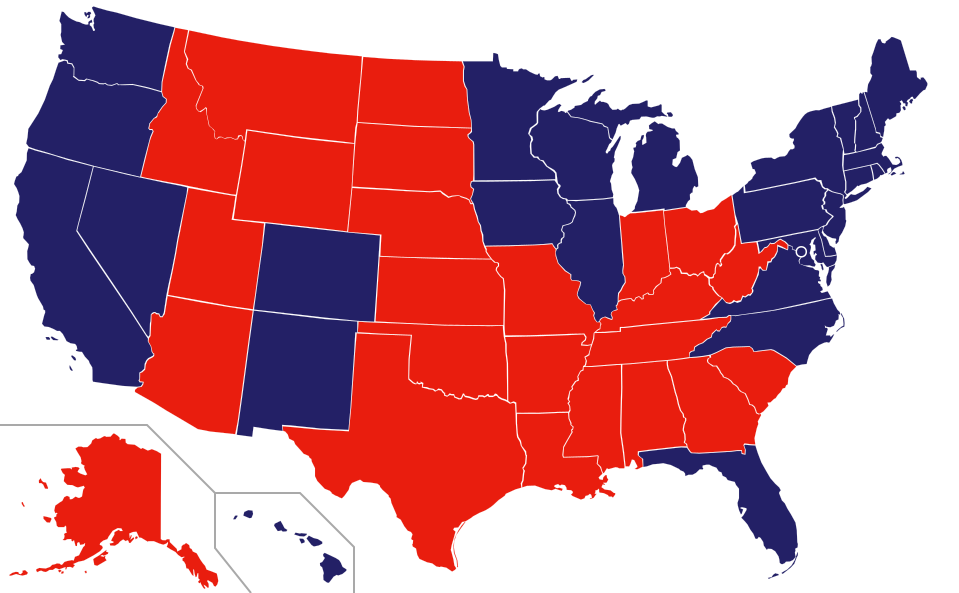

In [5]:
######################### VISUALIZATION special thanks to NATHAN YAU #########################
## http://flowingdata.com/2009/11/12/how-to-make-a-us-county-thematic-map-using-free-tools/ ##
##############################################################################################

stateIndex['Short'] = ['AL','AK','AZ','AR','CA','CO','CT','DC','DE','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY']

svg = urllib.request.urlopen('https://upload.wikimedia.org/wikipedia/commons/1/1a/Blank_US_Map_%28states_only%29.svg')
soup = BeautifulSoup(svg, "lxml")
paths = soup.findAll('path')
fixDC = soup.find('circle')
colors = ["#E91D0E", "#232066"] # GOP, DEM

path_style = 'font-size:12px;fill-rule:nonzero;stroke:#FFFFFF;stroke-opacity:1;stroke-width:0.1;stroke-miterlimit:4;stroke-dasharray:none;stroke-linecap:butt;marker-start:none;stroke-linejoin:bevel;fill:'

for p in paths:
     
    if p['id'] not in ["frames"]:
          
        if (stateIndex.Winner[stateIndex.Short.str.contains(p['id']).drop_duplicates(False).index[0]] == 'Trump'):
            color = "#E91D0E"
            p['style'] = path_style + color
        else:
            color = "#232066"
            p['style'] = path_style + color
    
if (stateIndex.Winner[stateIndex.Short.str.contains('DC').drop_duplicates(False).index[0]] == 'Trump'):
    fixDC['fill'] = "#E91D0E"
else:
    fixDC['fill'] = "#232066"

svgStateIndex = stateIndex.drop(7).reset_index()
i = 0
while i<=49:
    dataTag = soup.new_tag('title', id=('dataTag'+str(i)))
    paths[i].append(dataTag) 
    dataTag.string = str(svgStateIndex.Winner_Margin[i]) + '%'
    i = i + 1
fixDCTag = soup.new_tag('title', id='dataTag50')
fixDC.append(fixDCTag)
fixDCTag.string = str(stateIndex.Winner_Margin[7]) + '%'

print('            The current winner is predicted to be '+winner+' with '+str(winnerPercent)+'% of the Electoral Votes, based on '+str(pollDataRaw.shape[0])+' state polls')
SVG(data= soup.prettify())